[![Fixel Algorithms](https://i.imgur.com/AqKHVZ0.png)](https://fixelalgorithms.gitlab.io/)

# ResNet Model

> Notebook by:
> - Royi Avital RoyiAvital@fixelalgorithms.com

## Revision History

| Version | Date       | User        |Content / Changes                                                   |
|---------|------------|-------------|--------------------------------------------------------------------|
| 1.0.000 | 26/05/2024 | Royi Avital | First version                                                      |

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/AIProgram/2024_02/0092DeepLearningResNet.ipynb)

In [1]:
# Import Packages

# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Machine Learning
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import ParameterGrid

# Deep Learning
import torch
import torch.nn            as nn
import torch.nn.functional as F
from torch.optim.optimizer import Optimizer
from torch.optim.lr_scheduler import LRScheduler
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchinfo
from torchmetrics.classification import MulticlassAccuracy
import torchvision
from torchvision.transforms import v2 as TorchVisionTrns

# Miscellaneous
import copy
from enum import auto, Enum, unique
import math
import os
from platform import python_version
import random
import time

# Typing
from typing import Callable, Dict, Generator, List, Optional, Self, Set, Tuple, Union

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter
from IPython import get_ipython
from IPython.display import HTML, Image
from IPython.display import display
from ipywidgets import Dropdown, FloatSlider, interact, IntSlider, Layout, SelectionSlider
from ipywidgets import interact

2024-06-12 06:02:39.873196: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Notations

* <font color='red'>(**?**)</font> Question to answer interactively.
* <font color='blue'>(**!**)</font> Simple task to add code for the notebook.
* <font color='green'>(**@**)</font> Optional / Extra self practice.
* <font color='brown'>(**#**)</font> Note / Useful resource / Food for thought.

Code Notations:

```python
someVar    = 2; #<! Notation for a variable
vVector    = np.random.rand(4) #<! Notation for 1D array
mMatrix    = np.random.rand(4, 3) #<! Notation for 2D array
tTensor    = np.random.rand(4, 3, 2, 3) #<! Notation for nD array (Tensor)
tuTuple    = (1, 2, 3) #<! Notation for a tuple
lList      = [1, 2, 3] #<! Notation for a list
dDict      = {1: 3, 2: 2, 3: 1} #<! Notation for a dictionary
oObj       = MyClass() #<! Notation for an object
dfData     = pd.DataFrame() #<! Notation for a data frame
dsData     = pd.Series() #<! Notation for a series
hObj       = plt.Axes() #<! Notation for an object / handler / function handler
```

### Code Exercise

 - Single line fill

 ```python
 vallToFill = ???
 ```

 - Multi Line to Fill (At least one)

 ```python
 # You need to start writing
 ????
 ```

 - Section to Fill

```python
#===========================Fill This===========================#
# 1. Explanation about what to do.
# !! Remarks to follow / take under consideration.
mX = ???

???
#===============================================================#
```

In [2]:
# Configuration
# %matplotlib inline

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

# Matplotlib default color palette
lMatPltLibclr = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# sns.set_theme() #>! Apply SeaBorn theme

runInGoogleColab = 'google.colab' in str(get_ipython())

# Improve performance by benchmarking
torch.backends.cudnn.benchmark = True

# Reproducibility (Per PyTorch Version on the same device)
# torch.manual_seed(seedNum)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark     = False #<! Makes things slower


In [3]:
# Constants

FIG_SIZE_DEF    = (8, 8)
ELM_SIZE_DEF    = 50
CLASS_COLOR     = ('b', 'r')
EDGE_COLOR      = 'k'
MARKER_SIZE_DEF = 10
LINE_WIDTH_DEF  = 2

D_CLASSES_CIFAR_10  = {0: 'Airplane', 1: 'Automobile', 2: 'Bird', 3: 'Cat', 4: 'Deer', 5: 'Dog', 6: 'Frog', 7: 'Horse', 8: 'Ship', 9: 'Truck'}
L_CLASSES_CIFAR_10  = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
T_IMG_SIZE_CIFAR_10 = (32, 32, 3)

DATA_FOLDER_PATH    = 'Data'
TENSOR_BOARD_BASE   = 'TB'


In [4]:
# Download Auxiliary Modules for Google Colab
if runInGoogleColab:
    !wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/AIProgram/2024_02/DataManipulation.py
    !wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/AIProgram/2024_02/DataVisualization.py
    !wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/AIProgram/2024_02/DeepLearningPyTorch.py

In [5]:
# Courses Packages
import sys
sys.path.append('/home/vlad/utils')  
from DataVisualization import PlotLabelsHistogram, PlotMnistImages
from DeepLearningPyTorch import NNMode, ResidualBlock
from DeepLearningPyTorch import InitWeightsKaiNorm, TrainModel


In [6]:
# General Auxiliary Functions



## The ResNet Model

The ResNet model is considered to be one of the most successful architectures.  
Its main novelty is the _Skip Connection_ which improved the performance greatly.

By _hand waiving_ the contribution of the skip connection can be explained as:

 * Learn the Residual  
   When looking for features, instead of extracting them from the image all needed is to emphasize them.  
   Namely, as a block, since the input is given, the active path only learns the residual.
 * Ensemble of Models  
   Since the data can move forward in many paths, one can see each path as a model.
 * Skip Vanishing Gradients   
   If the gradient is vanishing at a path, the skip connection can skip it during backpropagation.


This notebook presents:
 - Review a model based on a paper.
 - Implement the _Residual Block_.
 - Implement a _ResNet_ like model.
 - Train the model on _CIFAR10_ dataset.

</br>

* <font color='brown'>(**#**)</font> A great recap on ResNet is given in the book [Dive into Deep Learning](https://d2l.ai): [Residual Networks (ResNet) and ResNeXt](https://d2l.ai/chapter_convolutional-modern/resnet.html).
* <font color='brown'>(**#**)</font> Analysis of the _Skip Connection_ is given in [Skip Connections Eliminate Singularities](https://arxiv.org/abs/1701.09175).
* <font color='brown'>(**#**)</font> Discussions and notes on _skip connection_: [CrossValidated - Neural Network with Skip Layer Connections](https://stats.stackexchange.com/questions/56950), [FastAI Forum - What’s the Intuition behind Skip Connections in ResNet](https://forums.fast.ai/t/63589).
* <font color='brown'>(**#**)</font> [Intuitive Explanation of Skip Connections in Deep Learning](https://theaisummer.com/skip-connections).

In [7]:
# Parameters

# Data
numSamplesPerClsTrain   = 4000
numSamplesPerClsVal     = 400

# Model
dropP = 0.5 #<! Dropout Layer

# Training
batchSize   = 256
numWork     = 2 #<! Number of workers
nEpochs     = 45

# Visualization
numImg = 3


## Generate / Load Data

Load the [CIFAR 10 Data Set](https://en.wikipedia.org/wiki/CIFAR-10).  
It is composed of 60,000 RGB images of size `32x32` with 10 classes uniformly spread.

* <font color='brown'>(**#**)</font> The dataset is retrieved using [Torch Vision](https://pytorch.org/vision/stable/index.html)'s built in datasets.  

In [8]:
# Load Data

dsTrain = torchvision.datasets.CIFAR10(root = DATA_FOLDER_PATH, train = True,  download = True, transform = torchvision.transforms.ToTensor())
dsVal   = torchvision.datasets.CIFAR10(root = DATA_FOLDER_PATH, train = False, download = True, transform = torchvision.transforms.ToTensor())
lClass  = dsTrain.classes


print(f'The training data set data shape: {dsTrain.data.shape}')
print(f'The validation data set data shape: {dsVal.data.shape}')
print(f'The unique values of the labels: {np.unique(lClass)}')

Files already downloaded and verified
Files already downloaded and verified
The training data set data shape: (50000, 32, 32, 3)
The validation data set data shape: (10000, 32, 32, 3)
The unique values of the labels: ['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


* <font color='brown'>(**#**)</font> The dataset is indexible (Subscriptable). It returns a tuple of the features and the label.
* <font color='brown'>(**#**)</font> While data is arranged as `H x W x C` the transformer, when accessing the data, will convert it into `C x H x W`. 

In [9]:
# Element of the Data Set

mX, valY = dsTrain[0]

print(f'The features shape: {mX.shape}')
print(f'The label value: {valY}')

The features shape: torch.Size([3, 32, 32])
The label value: 6


### Plot the Data

In [10]:
# Extract Data

tX = dsTrain.data #<! NumPy Tensor (NDarray)
mX = np.reshape(tX, (tX.shape[0], -1))
vY = dsTrain.targets #<! NumPy Vector


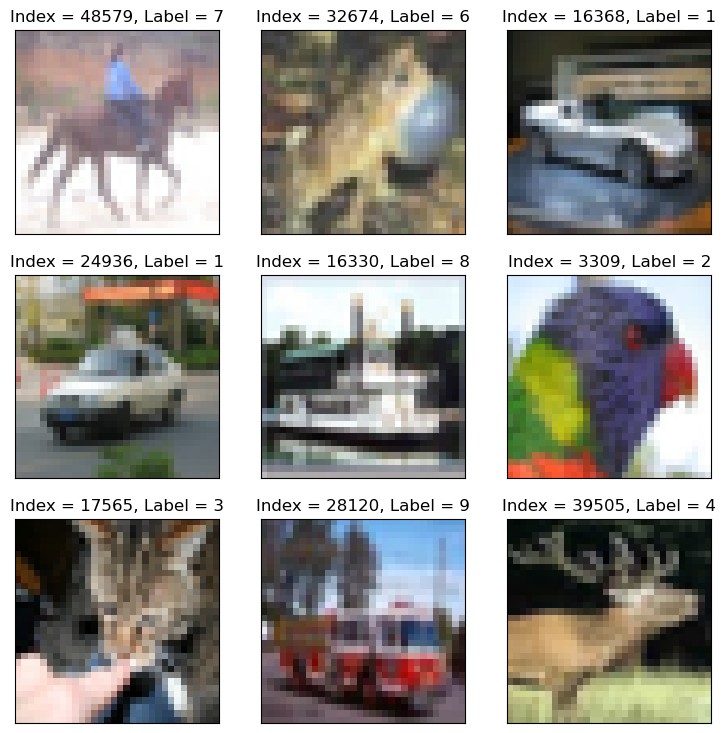

In [11]:
# Plot the Data

hF = PlotMnistImages(mX, vY, numImg, tuImgSize = T_IMG_SIZE_CIFAR_10)

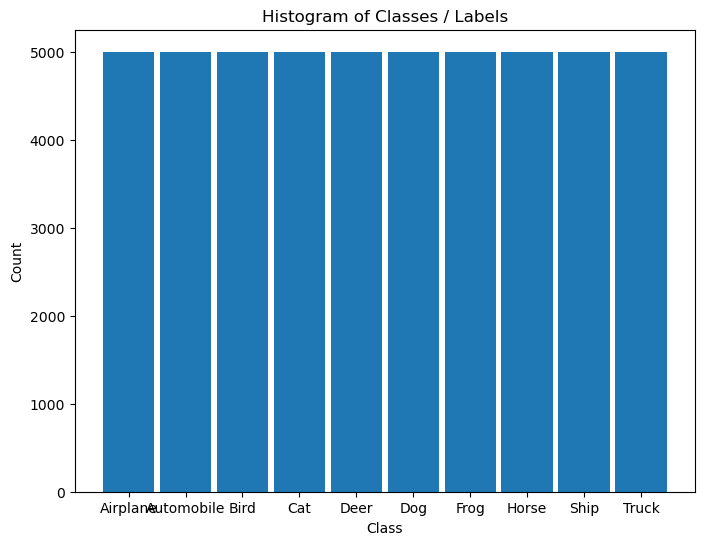

In [12]:
# Histogram of Labels

hA = PlotLabelsHistogram(vY, lClass = L_CLASSES_CIFAR_10)
plt.show()

* <font color='red'>(**?**)</font> If data is converted into _grayscale_, how would it effect the performance of the classifier? Explain.  
  You may assume the conversion is done using the mean value of the RGB pixel.

## Pre Process Data

This section:

 * Normalizes the data in a predefined manner.
 * Takes a sub set of the data.

In [13]:
# Calculate the Standardization Parameters
vMean = np.mean(dsTrain.data / 255.0, axis = (0, 1, 2))
vStd  = np.std(dsVal.data / 255.0, axis = (0, 1, 2))

print('µ =', vMean)
print('σ =', vStd)

µ = [0.49139968 0.48215841 0.44653091]
σ = [0.24665252 0.24289226 0.26159238]


In [14]:
# Update Transforms
# Using v2 Transforms
oDataTrnsTrain = TorchVisionTrns.Compose([
    TorchVisionTrns.ToImage(),
    TorchVisionTrns.ToDtype(torch.float32, scale = True),
    TorchVisionTrns.RandomHorizontalFlip(p = 0.5),
    TorchVisionTrns.Normalize(mean = vMean, std = vStd),
])
oDataTrnsVal = TorchVisionTrns.Compose([
    TorchVisionTrns.ToImage(),
    TorchVisionTrns.ToDtype(torch.float32, scale = True),
    TorchVisionTrns.Normalize(mean = vMean, std = vStd),
])

# Update the DS transformer
dsTrain.transform   = oDataTrnsTrain
dsVal.transform     = oDataTrnsVal

* <font color='red'>(**?**)</font> What does `RandomHorizontalFlip` do? Why can it be used?

--- we accept the model to know if the image is flipped or not - for real world image
why it is helping - it is helping to generalize the model and make the model not be sensitive to the orientation of the image; it is also helping to increase the size of the dataset;



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


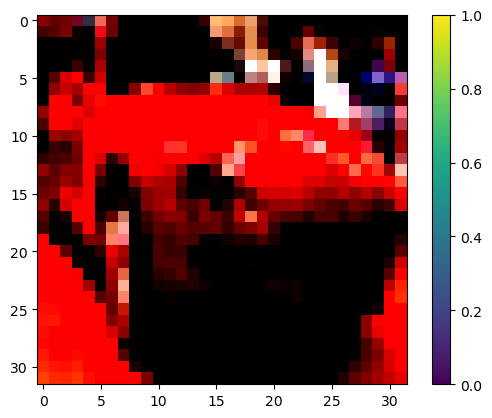

In [15]:
# "Normalized" Image

mX, valY = dsTrain[5]

hF, hA = plt.subplots()
hImg = hA.imshow(np.transpose(mX, (1, 2, 0)))
hF.colorbar(hImg)
plt.show()

### Data Loaders

This section defines the data loaded.



In [16]:
# Data Loader

dlTrain = torch.utils.data.DataLoader(dsTrain, shuffle = True, batch_size = 1 * batchSize, num_workers = numWork, persistent_workers = True)
dlVal   = torch.utils.data.DataLoader(dsVal, shuffle = False, batch_size = 2 * batchSize, num_workers = numWork, persistent_workers = True)


* <font color='red'>(**?**)</font> Why is the size of the batch twice as big for the test dataset?

In [17]:
# Iterate on the Loader
# The first batch.
tX, vY = next(iter(dlTrain)) #<! PyTorch Tensors

print(f'The batch features dimensions: {tX.shape}')
print(f'The batch labels dimensions: {vY.shape}')

The batch features dimensions: torch.Size([256, 3, 32, 32])
The batch labels dimensions: torch.Size([256])


In [18]:
# Looping
for ii, (tX, vY) in zip(range(1), dlVal): #<! https://stackoverflow.com/questions/36106712
    print(f'The batch features dimensions: {tX.shape}')
    print(f'The batch labels dimensions: {vY.shape}')

The batch features dimensions: torch.Size([512, 3, 32, 32])
The batch labels dimensions: torch.Size([512])


## Define the Model

The model is defined as a sequential model built with non sequential blocks.

In PyTorch models are defined by 2 main methods:
1. The `__init__()` Method  
   Set the parameters and elements of the model.
2. The `forward()` Method  
   Set the structure of the computation.

It holds whether the model is a layer or a sub module of a bigger model.

### The Residual Block

This section implements the residual block as an `torch.nn.Module`.

![](https://i.imgur.com/uCUvner.png)

* <font color='blue'>(**!**)</font> Got through the `ResidualBlock` class.
* <font color='brown'>(**#**)</font> The `ResidualBlock` class is an example of a non sequential model (Though it is a block).
* <font color='brown'>(**#**)</font> Some argue that the residual block in the following form yields better results:

```python
nn.Sequential(
            nn.BatchNorm2d(C), nn.ReLU(), nn.Conv2d(C, C, 3, padding = 1, bias = False),
            nn.BatchNorm2d(C), nn.ReLU(), nn.Conv2d(C, C, 3, padding = 1, bias = False)
)
```

```
class ResidualBlock( nn.Module ):
    def __init__( self, numChnl: int ) -> None:
        super(ResidualBlock, self).__init__()           // call infra init for all features support

        // define our struct //
        // * the class mode not functional to show better on info graph
        
        self.oConv2D1       = nn.Conv2d(numChnl, numChnl, kernel_size = 3, padding = 1, bias = False)
                                                                        // pad =1 = to keep the same exit size
        self.oBatchNorm1    = nn.BatchNorm2d(numChnl)
        self.oReLU1         = nn.ReLU(inplace = True)
        self.oConv2D2       = nn.Conv2d(numChnl, numChnl, kernel_size = 3, padding = 1, bias = False)
        self.oBatchNorm2    = nn.BatchNorm2d(numChnl)
        self.oReLU2         = nn.ReLU(inplace = True) #<! No need for it, for better visualization
            
    def forward( self: Self, tX: torch.Tensor ) -> torch.Tensor:
        
        tY = self.oReLU1(self.oBatchNorm1(self.oConv2D1(tX)))
        tY = self.oBatchNorm2(self.oConv2D2(tY))
        tY += tX
        tY = self.oReLU2(tY)
		
        return tY


```

In [19]:
# The Residual Block
oResBlock = ResidualBlock(64)
torchinfo.summary(oResBlock, (4, 64, 56, 56), col_names = ['kernel_size', 'output_size', 'num_params'], device = 'cpu')

Layer (type:depth-idx)                   Kernel Shape              Output Shape              Param #
ResidualBlock                            --                        [4, 64, 56, 56]           --
├─Conv2d: 1-1                            [3, 3]                    [4, 64, 56, 56]           36,864
├─BatchNorm2d: 1-2                       --                        [4, 64, 56, 56]           128
├─ReLU: 1-3                              --                        [4, 64, 56, 56]           --
├─Conv2d: 1-4                            [3, 3]                    [4, 64, 56, 56]           36,864
├─BatchNorm2d: 1-5                       --                        [4, 64, 56, 56]           128
├─ReLU: 1-6                              --                        [4, 64, 56, 56]           --
Total params: 73,984
Trainable params: 73,984
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 924.85
Input size (MB): 3.21
Forward/backward pass size (MB): 25.69
Params size (MB): 0.30
Estimated Total Size 

* <font color='green'>(**@**)</font> Implement the `ResidualBlock` class using `nn.Sequential` to describe the left path.


## optional : residul with learned param


* <font color='brown'>(**#**)</font> Assume the output of the _Residual Layer_ was $g \left( \boldsymbol{x} \right) = \alpha f \left( \boldsymbol{x} \right) + \left( 1 - \alpha \right) \boldsymbol{x}$.  
  If one would like $\alpha$ to be a learned parameter it would have ot be registered as such.  
  See [PyTorch: Custom nn Modules](https://pytorch.org/tutorials/beginner/examples_nn/polynomial_module.html), [Dive into Deep Learning - Builder's Guide - Custom Layers](https://d2l.ai/chapter_builders-guide/custom-layer.html), [Writing a Custom Layer in PyTorch](scribe.rip/14ab6ac94b77).


```
class ResidualBlock( nn.Module ):
    def __init__( self, numChnl: int ) -> None:
        super(ResidualBlock, self).__init__()           // call infra init for all features support

        //!!!!

        self.a = torch.nn.Parameter(torch.randn(()))

        //!!!!
        //........

```

## build model

In [20]:
# Model
# Defining a sequential model.

numChannels = 128

def BuildModel( nC: int ) -> nn.Module:

    oModel = nn.Sequential(
        nn.Identity(),
        nn.Conv2d(3, nC, 3, padding = 1, bias = False),  nn.BatchNorm2d(nC), nn.ReLU(),                  nn.Dropout2d(0.2),
        nn.Conv2d(nC, nC, 3, padding = 1, bias = False), nn.BatchNorm2d(nC), nn.ReLU(), nn.MaxPool2d(2), nn.Dropout2d(0.2),
        
        ResidualBlock(nC), nn.Dropout2d(0.2),
        ResidualBlock(nC), nn.Dropout2d(0.2),
        
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Linear(nC, 10)
    )

    oModel.apply(InitWeightsKaiNorm)

    return oModel

oModel = BuildModel(numChannels)

torchinfo.summary(oModel, (batchSize, 3, 32, 32), col_names = ['kernel_size', 'output_size', 'num_params'], device = 'cpu')

Layer (type:depth-idx)                   Kernel Shape              Output Shape              Param #
Sequential                               --                        [256, 10]                 --
├─Identity: 1-1                          --                        [256, 3, 32, 32]          --
├─Conv2d: 1-2                            [3, 3]                    [256, 128, 32, 32]        3,456
├─BatchNorm2d: 1-3                       --                        [256, 128, 32, 32]        256
├─ReLU: 1-4                              --                        [256, 128, 32, 32]        --
├─Dropout2d: 1-5                         --                        [256, 128, 32, 32]        --
├─Conv2d: 1-6                            [3, 3]                    [256, 128, 32, 32]        147,456
├─BatchNorm2d: 1-7                       --                        [256, 128, 32, 32]        256
├─ReLU: 1-8                              --                        [256, 128, 32, 32]        --
├─MaxPool2d: 1-9         

* <font color='green'>(**@**)</font> Use the default initialization and compare results.
* <font color='red'>(**?**)</font> What is the motivation to _build on your own_ the ResNet model instead of using the pre trained model?  
  Think about the dimensions of the dataset samples.

## Train the Model

This section trains the model using different schedulers:

 - Updates the training function to use more features of _TensorBoard_.
 - Trains the model with different _hyper parameters_.

In [21]:
# Run Device

runDevice = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #<! The 1st CUDA device
oModel    = oModel.to(runDevice) #<! Transfer model to device

In [22]:
# Loss and Score Function

hL = nn.CrossEntropyLoss()
hS = MulticlassAccuracy(num_classes = len(lClass), average = 'micro')
hL = hL.to(runDevice) #<! Not required!
hS = hS.to(runDevice)

* <font color='brown'>(**#**)</font> The averaging mode `macro` averages samples per class and average the result of each class.
* <font color='brown'>(**#**)</font> The averaging mode `micro` averages all samples.



* <font color='red'>(**?**)</font> Given 8 samples of class `A` with 6 predictions being correct and 2 samples of class `B` with 1 being correct.  
  What will be the _macro average_? What will be the _micro average_?



```
A (6/8) =>              macro (75 + 50 ) / 2 = 62.5%
B (1/2) = >             micro 7/10 = 70%

for inbalanced dataset, macro is better ; 
```

In [23]:
# Define Optimizer

oOpt = torch.optim.AdamW(oModel.parameters(), lr = 1e-3, betas = (0.9, 0.99), weight_decay = 1e-3) #<! Define optimizer

In [24]:
# Define Scheduler

oSch = torch.optim.lr_scheduler.OneCycleLR(oOpt, max_lr = 5e-3, total_steps = nEpochs)

In [25]:
# Train Model

oModel, lTrainLoss, lTrainScore, lValLoss, lValScore, lLearnRate = TrainModel(oModel, dlTrain, dlVal, oOpt, nEpochs, hL, hS, oSch = oSch)

Epoch    1 / 45 | Train Loss:  2.248 | Val Loss:  1.666 | Train Score:  0.241 | Val Score:  0.388 | Epoch Time: 34.75 | <-- Checkpoint! |
Epoch    2 / 45 | Train Loss:  1.842 | Val Loss:  1.485 | Train Score:  0.323 | Val Score:  0.465 | Epoch Time: 26.85 | <-- Checkpoint! |
Epoch    3 / 45 | Train Loss:  1.632 | Val Loss:  1.291 | Train Score:  0.396 | Val Score:  0.540 | Epoch Time: 26.50 | <-- Checkpoint! |
Epoch    4 / 45 | Train Loss:  1.423 | Val Loss:  1.148 | Train Score:  0.480 | Val Score:  0.594 | Epoch Time: 26.63 | <-- Checkpoint! |
Epoch    5 / 45 | Train Loss:  1.257 | Val Loss:  1.056 | Train Score:  0.544 | Val Score:  0.622 | Epoch Time: 28.36 | <-- Checkpoint! |
Epoch    6 / 45 | Train Loss:  1.129 | Val Loss:  0.942 | Train Score:  0.596 | Val Score:  0.659 | Epoch Time: 29.49 | <-- Checkpoint! |
Epoch    7 / 45 | Train Loss:  1.024 | Val Loss:  0.876 | Train Score:  0.636 | Val Score:  0.685 | Epoch Time: 28.71 | <-- Checkpoint! |
Epoch    8 / 45 | Train Loss:  0.9

Text(0, 0.5, 'Learn Rate')

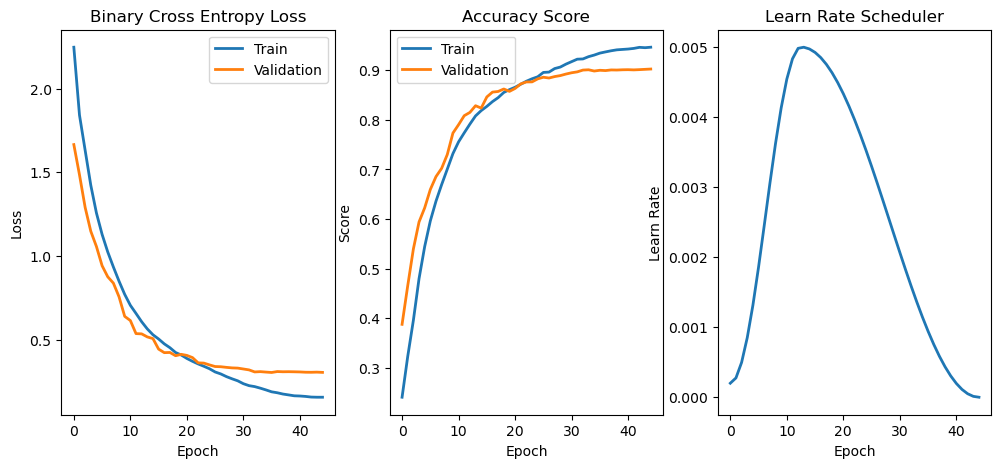

In [26]:
# Plot Training Phase

hF, vHa = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 5))
vHa = np.ravel(vHa)

hA = vHa[0]
hA.plot(lTrainLoss, lw = 2, label = 'Train')
hA.plot(lValLoss, lw = 2, label = 'Validation')
hA.set_title('Binary Cross Entropy Loss')
hA.set_xlabel('Epoch')
hA.set_ylabel('Loss')
hA.legend()

hA = vHa[1]
hA.plot(lTrainScore, lw = 2, label = 'Train')
hA.plot(lValScore, lw = 2, label = 'Validation')
hA.set_title('Accuracy Score')
hA.set_xlabel('Epoch')
hA.set_ylabel('Score')
hA.legend()

hA = vHa[2]
hA.plot(lLearnRate, lw = 2)
hA.set_title('Learn Rate Scheduler')
hA.set_xlabel('Epoch')
hA.set_ylabel('Learn Rate')

* <font color='blue'>(**!**)</font> Implement the ResNeXt like model. Start with the block and embed it into the model.